In [221]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib import patches
sns.set_style('whitegrid')
sns.set_color_codes()
sns.set_context('poster')
%matplotlib notebook

In [222]:
data = pd.read_csv('./hw_2_data/flowers.csv')

In [228]:
def plot_features(feature_list, color_by):
    axes = []
    if color_by.dtype not in (int, float):
        categories = color_by.unique()
        palette = sns.color_palette(palette='husl', n_colors=len(categories))
        colormap = {cat: palette[i] for i, cat in enumerate(categories)}
        colors = [colormap[color] for color in color_by]
        handles = [patches.Patch(color=colormap[cat]) for cat in categories]
        labels = categories
    else:
        colormap = ScalarMappable(cmap='viridis')
        colormap.set_array(color_by)
        colors = colormap.to_rgba(color_by)
    n_features = len(feature_list)
    fig = plt.figure(figsize=(3*n_features, 3*n_features))
    for i in range(n_features):
        for j in range(i+1):
            ax = plt.subplot(n_features, n_features, n_features*i+j+1)
            ax.set_xlim(min(feature_list[j]), max(feature_list[j]))
            ax.set_ylim(min(feature_list[i]), max(feature_list[i]))
            ax.scatter(feature_list[j], feature_list[i], color=colors, linewidth=0)
            if j != 0:
                plt.setp(ax.get_yticklabels(), visible=False)
            else:
                ax.set_ylabel(feature_list[i].name)
            if i != n_features-1:
                plt.setp(ax.get_xticklabels(), visible=False)
            else:
                ax.set_xlabel(feature_list[j].name)
            axes.append(ax)
    if color_by.dtype not in (int, float):
        handles
        fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0.9, 0.9), title=color_by.name)
    else:
        fig.colorbar(colormap, ax=axes, label=color_by.name)

<IPython.core.display.Javascript object>


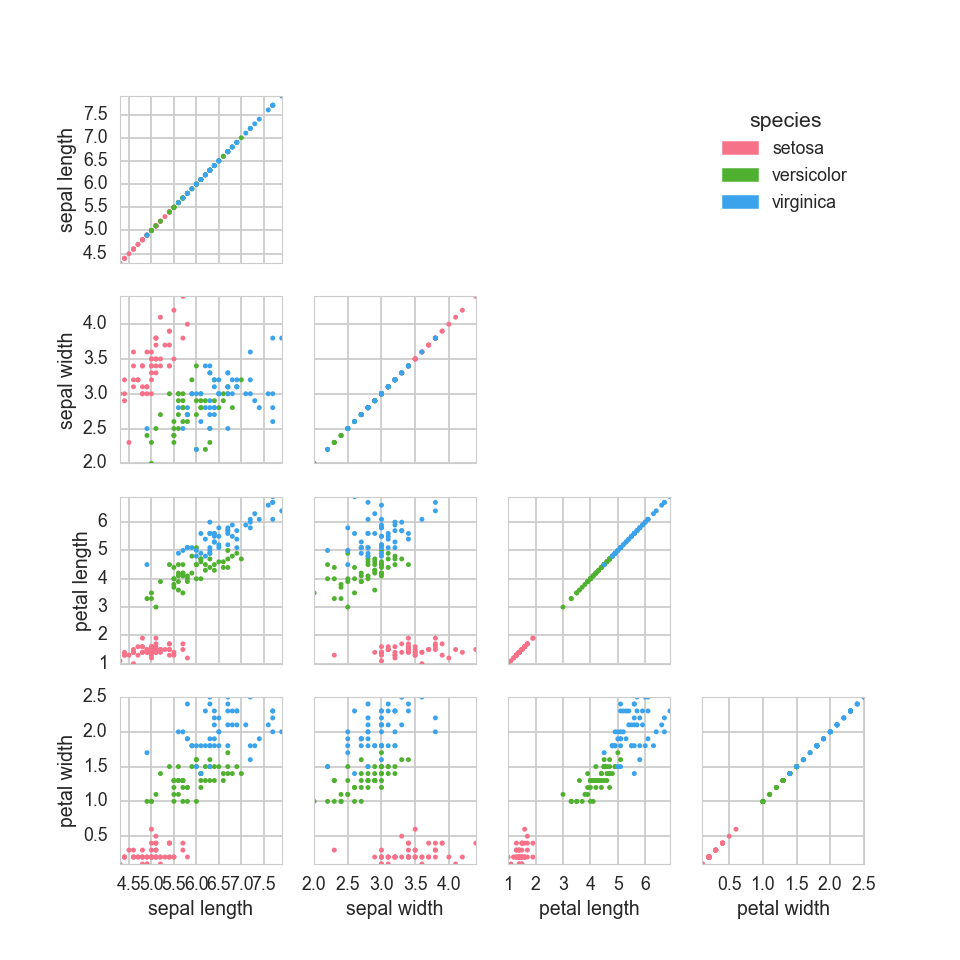

In [230]:
feature_list = [data['sepal length'],
                data['sepal width'],
                data['petal length'],
                data['petal width']]
plot_features(feature_list, color_by=data['species'])